<a href="https://colab.research.google.com/github/Kussil/Financial_Sentiment_LLM/blob/main/04_Stock_Modeling/Stock_Modeling_Prompt2_Gemini_ProQuest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Modeling using Gemini Sentiments

In [1]:
#install dependencies
!pip install -q ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.0 MB/s eta 0:00:00


In [2]:
# import libraries
import os
from google.colab import userdata
from google.colab import output
import pandas as pd
import yfinance as yf
import textwrap
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
output.enable_custom_widget_manager()

In [3]:
#Delete repo clone if needed
!rm -rf /content/CVX_Rice_project/

In [4]:
# Import github token with google secrets thingy and clone git repository
GITHUB_TOKEN = userdata.get('github')
os.environ['GITHUB_TOKEN'] = GITHUB_TOKEN
!git clone https://{GITHUB_TOKEN}@github.com/Kussil/Financial_Sentiment_LLM.git

Cloning into 'Financial_Sentiment_LLM'...
remote: Enumerating objects: 2365, done.
remote: Counting objects: 100% (770/770), done.
remote: Compressing objects: 100% (364/364), done.
remote: Total 2365 (delta 489), reused 660 (delta 393), pack-reused 1595
Receiving objects: 100% (2365/2365), 489.16 MiB | 15.37 MiB/s, done.
Resolving deltas: 100% (1572/1572), done.
Updating files: 100% (1179/1179), done.


In [5]:
# Read in outputs from Gemini Sentiment Analysis
gemini_prompt2_sentiment = pd.read_csv('/content/Financial_Sentiment_LLM/03_Sentiment_Analysis/Prompt2_Sentiment_Analysis_Results.csv')
gemini_prompt2_sentiment = gemini_prompt2_sentiment.fillna('')
gemini_prompt2_sentiment

,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves / Exploration / Acquisitions / Mergers / Divestments,Environment / Regulatory / Geopolitics,Alternative Energy / Lower Carbon,Oil Price / Natural Gas Price / Gasoline Price
0,Investment Research,IR-1,MRO,5/16/2024,,Positive,Neutral,Positive,Negative,Neutral,Neutral
1,Investment Research,IR-2,EOG,5/14/2024,,Positive,Positive,Positive,Neutral,Positive,Neutral
2,Investment Research,IR-3,EOG,5/11/2024,,Positive,Positive,Positive,Neutral,Neutral,Neutral
3,Investment Research,IR-4,DVN,5/11/2024,,Positive,Positive,Negative,Neutral,Neutral,Neutral
4,Investment Research,IR-5,COP,5/7/2024,,Neutral,Neutral,Positive,Negative,Neutral,Positive
...,...,...,...,...,...,...,...,...,...,...,...
10047,Earnings Call Q&A,EQ-338,XOM,2/2/2021,,Positive,Neutral,Positive,Positive,Positive,Neutral
10048,Earnings Call Q&A,EQ-339,COP,2/2/2021,,Positive,Neutral,Positive,Neutral,Positive,Neutral
10049,Earnings Call Q&A,EQ-340,EOG,5/3/2019,,Positive,Positive,Positive,Neutral,Neutral,Neutral
10050,Earnings Call Q&A,EQ-341,SHEL,5/2/2019,,Positive,Positive,Neutral,Neutral,Neutral,Neutral


In [6]:
source_values = gemini_prompt2_sentiment["Source"].unique()
source_values


array(['Investment Research', 'ProQuest', 'SEC Filings',
       'Earnings Call Presentations', 'Earnings Call Q&A'], dtype=object)

In [10]:
# Define a list of date formats
date_formats = [
    '%d/%m/%Y',  # 01/01/2021
    '%m/%d/%Y',  # 5/16/2024
    '%Y-%m-%d',  # 2021-02-28
    '%B %d, %Y',  # March 15, 2021
    '%b-%d-%Y',  # Apr-30-2019
    '%Y.%m.%d',  # 2021.04.10
    '%m-%d-%Y',  # 04-10-2021
    '%d-%b-%y',  # 17-Aug-22
    '%b-%y'  # Sep-19
]

# Function to parse dates with multiple formats
def parse_date(date_str):
    for fmt in date_formats:
        try:
            # Handle special case where only month and year are given
            if fmt == '%b-%y':
                parsed_date = datetime.strptime(date_str, fmt)
                # Default to the first day of the month
                return parsed_date.replace(day=1)
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    raise ValueError(f"Date format not recognized: {date_str}")

# Apply the function to the 'Date' column
gemini_prompt2_sentiment['Date'] = gemini_prompt2_sentiment['Date'].apply(parse_date)

# Format the dates in a specific string format
gemini_prompt2_sentiment['Date'] = gemini_prompt2_sentiment['Date'].dt.strftime('%Y-%m-%d')

# Modifying the original dataframe to only include rows where the source is "Proquest"
gemini_prompt2_sentiment = gemini_prompt2_sentiment[gemini_prompt2_sentiment["Source"] == "ProQuest"]

# Display the DataFrame
gemini_prompt2_sentiment

,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves / Exploration / Acquisitions / Mergers / Divestments,Environment / Regulatory / Geopolitics,Alternative Energy / Lower Carbon,Oil Price / Natural Gas Price / Gasoline Price
4880,ProQuest,PQ-2703147472,CVX,2022-08-17,https://www.proquest.com/newspapers/chevron-ge...,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral
4881,ProQuest,PQ-2702197510,CVX,2022-08-15,https://www.proquest.com/newspapers/chevron-sl...,Negative,Negative,Neutral,Neutral,Positive,Negative
4882,ProQuest,PQ-2697049245,CVX,2022-02-08,https://www.proquest.com/newspapers/chevron-sl...,Negative,Neutral,Neutral,Neutral,Neutral,Negative
4883,ProQuest,PQ-2696371267,CVX,2022-07-30,https://www.proquest.com/newspapers/senators-a...,Neutral,Neutral,Negative,Negative,Neutral,Neutral
4884,ProQuest,PQ-2695835797,CVX,2022-07-29,https://www.proquest.com/newspapers/shell-trie...,Positive,Neutral,Negative,Positive,Positive,Neutral
...,...,...,...,...,...,...,...,...,...,...,...
8509,ProQuest,PQ-2238653651,PSX,2019-12-06,https://www.proquest.com/newspapers/as-price-g...,Neutral,Neutral,Neutral,Neutral,Neutral,Negative
8510,ProQuest,PQ-2239478009,PSX,2019-10-06,https://www.proquest.com/newspapers/phillips-6...,Positive,Neutral,Neutral,Neutral,Neutral,Neutral
8511,ProQuest,PQ-2238860015,PSX,2019-07-06,https://www.proquest.com/newspapers/autonomous...,Positive,Neutral,Neutral,Positive,Neutral,Neutral
8512,ProQuest,PQ-2233473767,PSX,2019-03-06,https://www.proquest.com/newspapers/united-sta...,Negative,Neutral,Neutral,Neutral,Neutral,Negative


In [11]:
# Renaming the columns to simplify sentiment categories
gemini_prompt2_sentiment.rename(columns={
    'Reserves / Exploration / Acquisitions / Mergers / Divestments': 'Reserves/M&A',
    'Environment / Regulatory / Geopolitics': 'Regulatory',
    'Alternative Energy / Lower Carbon': 'Green Energy',
    'Oil Price / Natural Gas Price / Gasoline Price': 'OG Price'
}, inplace=True)

gemini_prompt2_sentiment

<ipython-input-11-a0f0210b1a72>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gemini_prompt2_sentiment.rename(columns={


,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price
4880,ProQuest,PQ-2703147472,CVX,2022-08-17,https://www.proquest.com/newspapers/chevron-ge...,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral
4881,ProQuest,PQ-2702197510,CVX,2022-08-15,https://www.proquest.com/newspapers/chevron-sl...,Negative,Negative,Neutral,Neutral,Positive,Negative
4882,ProQuest,PQ-2697049245,CVX,2022-02-08,https://www.proquest.com/newspapers/chevron-sl...,Negative,Neutral,Neutral,Neutral,Neutral,Negative
4883,ProQuest,PQ-2696371267,CVX,2022-07-30,https://www.proquest.com/newspapers/senators-a...,Neutral,Neutral,Negative,Negative,Neutral,Neutral
4884,ProQuest,PQ-2695835797,CVX,2022-07-29,https://www.proquest.com/newspapers/shell-trie...,Positive,Neutral,Negative,Positive,Positive,Neutral
...,...,...,...,...,...,...,...,...,...,...,...
8509,ProQuest,PQ-2238653651,PSX,2019-12-06,https://www.proquest.com/newspapers/as-price-g...,Neutral,Neutral,Neutral,Neutral,Neutral,Negative
8510,ProQuest,PQ-2239478009,PSX,2019-10-06,https://www.proquest.com/newspapers/phillips-6...,Positive,Neutral,Neutral,Neutral,Neutral,Neutral
8511,ProQuest,PQ-2238860015,PSX,2019-07-06,https://www.proquest.com/newspapers/autonomous...,Positive,Neutral,Neutral,Positive,Neutral,Neutral
8512,ProQuest,PQ-2233473767,PSX,2019-03-06,https://www.proquest.com/newspapers/united-sta...,Negative,Neutral,Neutral,Neutral,Neutral,Negative


In [12]:
#Create Positive and Negative Ratios for each row

# Columns to consider for calculating ratios
columns_to_check = ['Finance', 'Production', 'Reserves/M&A', 'Regulatory', 'Green Energy', 'OG Price']

# Function to calculate positive and negative ratios
def calculate_ratios(row):
    positive_count = (row[columns_to_check] == 'Positive').sum()
    negative_count = (row[columns_to_check] == 'Negative').sum()
    neutral_count = (row[columns_to_check] == 'Neutral').sum()
    total_count = len(columns_to_check)
    pos_ratio = positive_count / total_count
    neg_ratio = negative_count / total_count
    neu_ratio = neutral_count / total_count
    return pd.Series([pos_ratio, neg_ratio, neu_ratio], index=['Pos_Ratio', 'Neg_Ratio', 'Neu_Ratio'])

# Apply the function to each row
gemini_prompt2_sentiment[['Pos_Ratio', 'Neg_Ratio', 'Neu_Ratio']] = gemini_prompt2_sentiment.apply(calculate_ratios, axis=1)

# Replace senitment category values with binary equivalents
binary_mapping = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
gemini_prompt2_sentiment[columns_to_check] = gemini_prompt2_sentiment[columns_to_check].replace(binary_mapping)

gemini_prompt2_sentiment

<ipython-input-12-aafc2392149c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gemini_prompt2_sentiment[['Pos_Ratio', 'Neg_Ratio', 'Neu_Ratio']] = gemini_prompt2_sentiment.apply(calculate_ratios, axis=1)
<ipython-input-12-aafc2392149c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gemini_prompt2_sentiment[['Pos_Ratio', 'Neg_Ratio', 'Neu_Ratio']] = gemini_prompt2_sentiment.apply(calculate_ratios, axis=1)
<ipython-input-12-aafc2392149c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy

,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price,Pos_Ratio,Neg_Ratio,Neu_Ratio
4880,ProQuest,PQ-2703147472,CVX,2022-08-17,https://www.proquest.com/newspapers/chevron-ge...,0,0,0,0,0,0,0.000000,0.000000,1.000000
4881,ProQuest,PQ-2702197510,CVX,2022-08-15,https://www.proquest.com/newspapers/chevron-sl...,-1,-1,0,0,1,-1,0.166667,0.500000,0.333333
4882,ProQuest,PQ-2697049245,CVX,2022-02-08,https://www.proquest.com/newspapers/chevron-sl...,-1,0,0,0,0,-1,0.000000,0.333333,0.666667
4883,ProQuest,PQ-2696371267,CVX,2022-07-30,https://www.proquest.com/newspapers/senators-a...,0,0,-1,-1,0,0,0.000000,0.333333,0.666667
4884,ProQuest,PQ-2695835797,CVX,2022-07-29,https://www.proquest.com/newspapers/shell-trie...,1,0,-1,1,1,0,0.500000,0.166667,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8509,ProQuest,PQ-2238653651,PSX,2019-12-06,https://www.proquest.com/newspapers/as-price-g...,0,0,0,0,0,-1,0.000000,0.166667,0.833333
8510,ProQuest,PQ-2239478009,PSX,2019-10-06,https://www.proquest.com/newspapers/phillips-6...,1,0,0,0,0,0,0.166667,0.000000,0.833333
8511,ProQuest,PQ-2238860015,PSX,2019-07-06,https://www.proquest.com/newspapers/autonomous...,1,0,0,1,0,0,0.333333,0.000000,0.666667
8512,ProQuest,PQ-2233473767,PSX,2019-03-06,https://www.proquest.com/newspapers/united-sta...,-1,0,0,0,0,-1,0.000000,0.333333,0.666667


In [13]:
#Identify minimum article date for stock price download
min_date = gemini_prompt2_sentiment['Date'].min()
min_date

'2019-01-06'

In [14]:
ticker_list = gemini_prompt2_sentiment['Ticker'].unique().tolist()
ticker_list

['CVX',
 'XOM',
 'OXY',
 'SHEL',
 'BP',
 'COP',
 'MPC',
 'CXO',
 'EQNR',
 'TTE',
 'PXD',
 'EOG',
 'DVN',
 'HES',
 'PSX']

In [15]:
#Pull YahooFinance stock data to get Returns (ret)
all_data = {}

for ticker in ticker_list:
    try:
        # Get the last date for the current ticker from gemini_prompt1_sentiment
        last_date = gemini_prompt2_sentiment[gemini_prompt2_sentiment['Ticker'] == ticker]['Date'].max()
        if pd.isna(last_date):
            print(f"No data available for {ticker} in gemini_prompt1_sentiment.")
            continue

        # Ensure the date is in the correct format
        last_date = pd.to_datetime(last_date).strftime('%Y-%m-%d')
        print(f"Downloading data for {ticker} from {min_date} to {last_date}")

        # Download stock data
        data = yf.download(ticker, start=min_date, end=last_date)["Adj Close"]

        if data.empty:
            print(f"No data retrieved for {ticker}")
        else:
            all_data[ticker] = data

    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")

# Combine all data into a single DataFrame
if all_data:
    price_df = pd.DataFrame(all_data)
    ret_df = price_df.pct_change().dropna()
    ret_df.name = "ret"
    ret_df.describe()
else:
    print("No data available.")

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CXO']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


No data retrieved for CXO


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


In [16]:
ret_df.describe()

,CVX,XOM,OXY,SHEL,BP,COP,MPC,EQNR,TTE,PXD,EOG,DVN,HES,PSX
count,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000,1380.000000
mean,0.000648,0.000758,0.000853,0.000414,0.000413,0.000937,0.001138,0.000714,0.000139,0.001072,0.000671,0.001312,0.001345,0.000816
std,0.021585,0.020864,0.038115,0.022354,0.022820,0.027136,0.028244,0.023814,0.016568,0.028738,0.028142,0.036156,0.030316,0.025692
min,-0.221248,-0.122248,-0.520138,-0.171722,-0.191040,-0.248401,-0.270089,-0.210562,-0.178208,-0.369197,-0.320072,-0.373972,-0.336685,-0.158658
25%,-0.008448,-0.010165,-0.014575,-0.008656,-0.009958,-0.011783,-0.009782,-0.011391,0.000000,-0.013155,-0.009518,-0.016361,-0.014165,-0.010411
50%,0.000733,0.000388,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000343,0.001092,0.000398
75%,0.009506,0.011210,0.014609,0.009619,0.009766,0.014049,0.012703,0.013526,0.000000,0.013858,0.009816,0.017542,0.015243,0.013434
max,0.227407,0.126868,0.336977,0.196795,0.216053,0.252138,0.206286,0.133042,0.152756,0.204343,0.165703,0.210721,0.203153,0.221723


In [17]:
# add overall article sentiment
df_sentiment = gemini_prompt2_sentiment

# Function to calculate positive and negative ratios
def calculate_ratios2(row):
    positive_count = (row[columns_to_check] == 1).sum()
    negative_count = (row[columns_to_check] == -1).sum()
    neutral_count = (row[columns_to_check] == 0).sum()
    total_count = len(columns_to_check)
    pos_ratio = positive_count / total_count
    neg_ratio = negative_count / total_count
    neu_ratio = neutral_count / total_count
    return pd.Series([pos_ratio, neg_ratio, neu_ratio], index=['Pos_Ratio2', 'Neg_Ratio2', 'Neu_Ratio2'])

# Apply the function to each row
df_sentiment[['Pos_Ratio2', 'Neg_Ratio2', 'Neu_Ratio2']] = df_sentiment.apply(calculate_ratios2, axis=1)


# aggregate by ticker and date
df_grouped = df_sentiment.groupby(['Ticker', 'Date']).agg(
    article_count=('Unique_ID', 'size'),
    Finance=('Finance', 'sum'),
    Production=('Production', 'sum'),
    Reserves_MA=('Reserves/M&A', 'sum'),
    Regulatory=('Regulatory', 'sum'),
    Green_Energy=('Green Energy', 'sum'),
    OG_Price=('OG Price', 'sum'),
    Neu_ratio_avg=('Neu_Ratio2','mean'),
    Pos_ratio_avg=('Pos_Ratio2','mean'),
    Neg_ratio_avg=('Neg_Ratio2','mean')
).reset_index()

# Adding Date String column
df_grouped['Date String'] = df_grouped['Date'].astype(str)


# reshape ret same day
ret_stack = ret_df.stack().reset_index()
ret_stack.columns = ['Date', 'Ticker', 'Returns']
ret_stack['Date'] = pd.to_datetime(ret_stack['Date'], format='mixed')
ret_stack['Date']= pd.to_datetime(ret_stack['Date']).dt.date
ret_stack['Date String']= ret_stack['Date'].astype(str)
ret_stack.drop(columns=['Date'], inplace=True)

# merge in returns for the day from YahooFinance
df_merged = pd.merge(df_grouped, ret_stack, on=['Ticker', 'Date String'], how='left')
df_merged.drop(columns=['Date String'], inplace=True)
df_merged = df_merged.sort_values(['Ticker', 'Date'])

# Fill NaN values with the next day's value within the same 'Ticker'
df_merged['Returns (no NaN)'] = df_merged.groupby('Ticker')['Returns'].fillna(method='bfill')
df_merged['Returns Next Day'] = df_merged.groupby('Ticker')['Returns'].shift(-1)
df_merged['Returns Next Day(no NaN)'] = df_merged.groupby('Ticker')['Returns Next Day'].fillna(method='bfill')
df_merged['Returns Next Day(no NaN)'] = df_merged['Returns Next Day(no NaN)'].fillna(df_merged['Returns (no NaN)'])
df_merged

<ipython-input-17-1cfb6f145679>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment[['Pos_Ratio2', 'Neg_Ratio2', 'Neu_Ratio2']] = df_sentiment.apply(calculate_ratios2, axis=1)
<ipython-input-17-1cfb6f145679>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment[['Pos_Ratio2', 'Neg_Ratio2', 'Neu_Ratio2']] = df_sentiment.apply(calculate_ratios2, axis=1)
<ipython-input-17-1cfb6f145679>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

,Ticker,Date,article_count,Finance,Production,Reserves_MA,Regulatory,Green_Energy,OG_Price,Neu_ratio_avg,Pos_ratio_avg,Neg_ratio_avg,Returns,Returns (no NaN),Returns Next Day,Returns Next Day(no NaN)
0,BP,2019-01-09,1,1,0,1,0,0,0,0.666667,0.333333,0.000000,0.008244,0.008244,-0.006590,-0.006590
1,BP,2019-02-11,1,0,0,0,0,0,0,1.000000,0.000000,0.000000,-0.006590,-0.006590,NaN,0.001894
2,BP,2019-03-10,1,1,0,0,-1,0,0,0.666667,0.166667,0.166667,NaN,0.001894,0.001894,0.001894
3,BP,2019-03-11,1,1,0,0,0,-1,0,0.666667,0.166667,0.166667,0.001894,0.001894,-0.005306,-0.005306
4,BP,2019-04-09,1,0,1,0,0,0,0,0.833333,0.166667,0.000000,-0.005306,-0.005306,0.001111,0.001111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2341,XOM,2024-09-02,1,0,1,0,-1,0,0,0.666667,0.166667,0.166667,NaN,NaN,NaN,NaN
2342,XOM,2024-09-05,1,-1,0,-1,-1,0,0,0.500000,0.000000,0.500000,NaN,NaN,NaN,NaN
2343,XOM,2024-10-01,1,1,1,1,0,0,1,0.333333,0.666667,0.000000,NaN,NaN,NaN,NaN
2344,XOM,2024-10-05,2,-2,0,-2,-2,1,0,0.250000,0.166667,0.583333,NaN,NaN,NaN,NaN


In [18]:
# save csv locally
df_merged.to_csv('/content/sample_data/sent_stock_data_prompt2_gemini_proquest.csv', index=False)



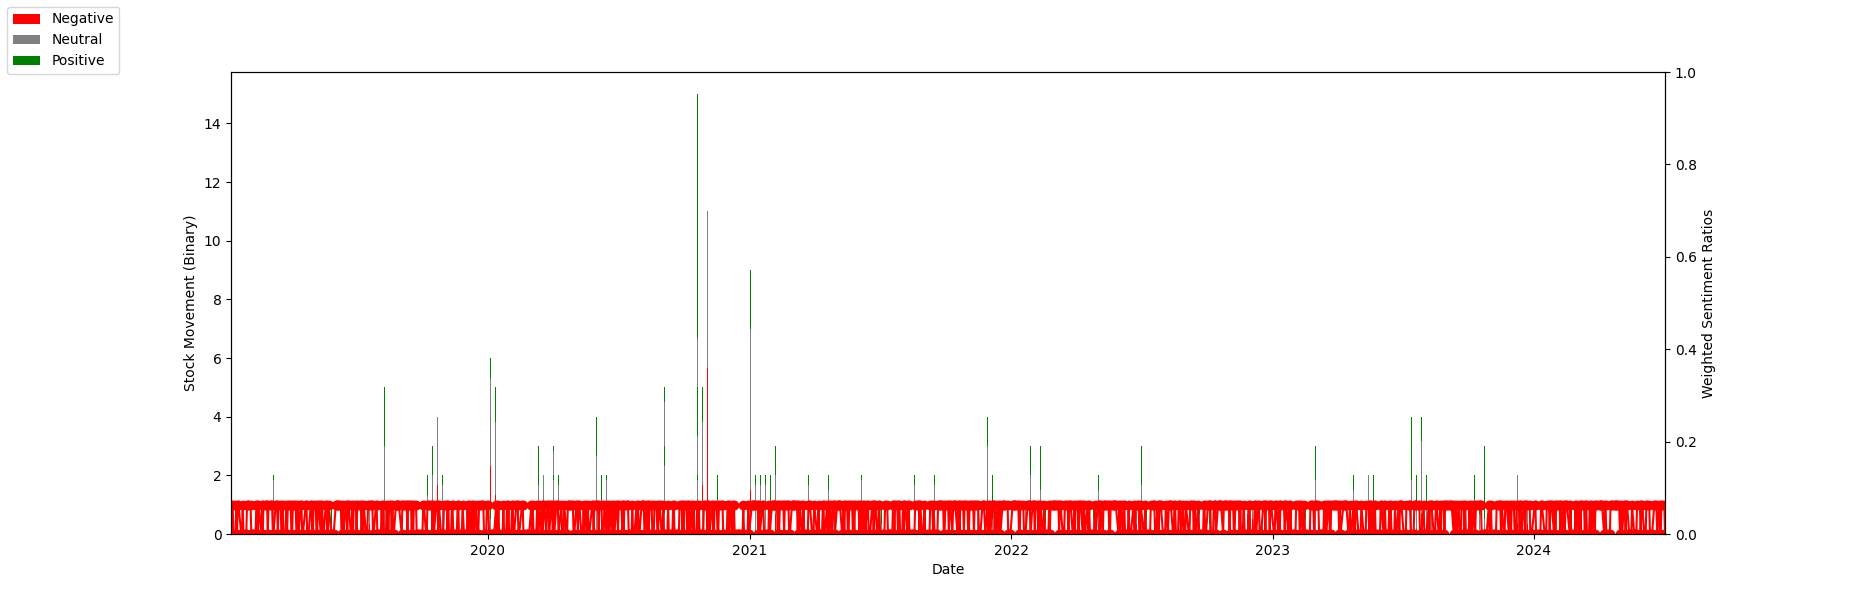

In [19]:
# Visualize Example Stock Price Movements (Up/Down) with Article Counts
%matplotlib ipympl
tz = pytz.timezone('America/New_York')

fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 6, forward=True)

tolerance = 2  # points

ret_binary = ret_df['CVX'].apply(lambda x: 1 if x > 0.0 else 0)

ax1.plot(ret_df.index, ret_binary, 'ro-', picker=tolerance)

# Calculate weighted values
dates = df_merged['Date']
weights = {
    "Negative": (df_merged['Neg_ratio_avg'] * df_merged['article_count']).tolist(),
    "Neutral": (df_merged['Neu_ratio_avg'] * df_merged['article_count']).tolist(),
    "Positive": (df_merged['Pos_ratio_avg'] * df_merged['article_count']).tolist()
}

colors = {
    "Negative": 'red',
    "Neutral": 'gray',
    "Positive": 'green'
}

ax2 = ax1.twinx()

width = 0.1
bottom = np.zeros(len(dates))

for sentiment, weight in weights.items():
    p = ax1.bar(dates, weight, width, label=sentiment, bottom=bottom, color=colors[sentiment])
    bottom += weight

ax1.set_xlim(left=ret_df.index.min(), right=ret_df.index.max())
ax2.set_xlim(left=ret_df.index.min(), right=ret_df.index.max())

# Add labels and legend
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Movement (Binary)')
ax2.set_ylabel('Weighted Sentiment Ratios')
fig.legend(loc='upper left')

plt.show()




def onclick(event):
    line = event.artist
    xdata, ydata = line.get_data()
    ind = event.ind
    datetime_obj  = xdata[ind][0].astype('datetime64[s]').astype(datetime)
    formatted_date = datetime_obj.strftime('%Y-%m-%d')
    print(formatted_date)
    #query = 'summarize the top news articles for chevron?'
    #top_results = 3
    #print(textwrap.fill(ask_vector_query(query, top_results, date=str(formatted_date), pinecone_index = "newsembedding3"), width=80))

#cid = fig.canvas.mpl_connect('button_press_event', onclick)
cid = fig.canvas.mpl_connect('pick_event', onclick)

In [20]:
# prep data for modeling
df_merged_drop = df_merged.drop(['Returns','Returns Next Day', 'Returns Next Day(no NaN)'], axis=1)
df_dropna = df_merged_drop.dropna()

# Convert the 'Date' column to datetime
df_dropna['Date'] = pd.to_datetime(df_dropna['Date'])

# Define the split date
base_date = pd.to_datetime('2022-01-01')
split_date = pd.to_datetime('2024-01-01')

# Split the DataFrame
train_df = df_dropna[(df_dropna['Date'] < split_date) & (df_dropna['Date'] >= base_date)]
test_df = df_dropna[df_dropna['Date'] >= split_date]

# define input variables
X_train_df = train_df.drop(columns=['Date','Ticker','Returns (no NaN)'])
X_test_df = test_df.drop(columns=['Date','Ticker','Returns (no NaN)'])

# define target variable
y_train_df = train_df['Returns (no NaN)'].apply(lambda x: 1 if x > 0.0 else 0)
y_test_df = test_df['Returns (no NaN)'].apply(lambda x: 1 if x > 0.0 else 0)

# Split the dataset into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# If you need to separate features and labels
X_train = X_train_df
y_train = y_train_df

X_test = X_test_df
y_test = y_test_df

print(len(X_train), len(y_train), len(X_test), len(y_test))

927 927 86 86


<ipython-input-20-36853a949fb5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna['Date'] = pd.to_datetime(df_dropna['Date'])


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Accuracy: 0.6162790697674418
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.56      0.63        50
           1       0.53      0.69      0.60        36

    accuracy                           0.62        86
   macro avg       0.62      0.63      0.62        86
weighted avg       0.64      0.62      0.62        86

Index(['article_count', 'Finance', 'Production', 'Reserves_MA', 'Regulatory',
       'Green_Energy', 'OG_Price', 'Neu_ratio_avg', 'Pos_ratio_avg',
       'Neg_ratio_avg'],
      dtype='object')
[0.05905958 0.11076044 0.09792736 0.10816782 0.10279373 0.07860572
 0.10297329 0.13159902 0.10778521 0.10032781]


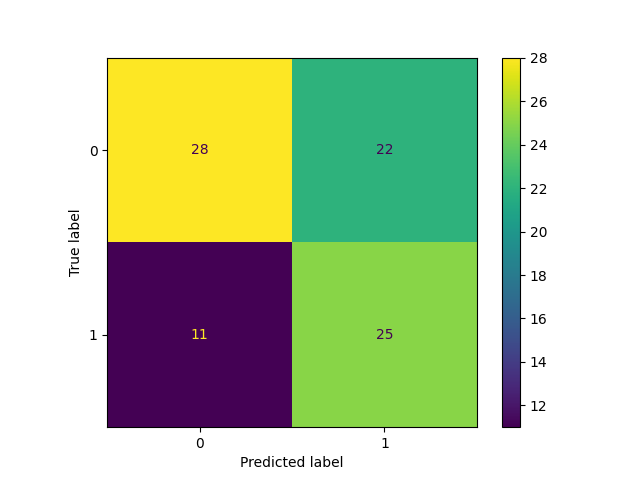

In [21]:
######## Train Random Forest Model ############

# Define the parameter grid
#param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [None, 10, 20, 30],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'bootstrap': [True, False]
#}
param_grid = {
    'n_estimators': [300],
    'max_depth': [None],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'max_features': ['auto'],
    'bootstrap': [True]
}

# Create a Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Train the classifier on the training set
grid_search.fit(X_train, y_train)

# Output the best parameters
print(grid_search.best_params_)

# Use the best estimator for predictions
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(X_train_df.columns)
print(best_model.feature_importances_)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.8}
Accuracy: 0.5697674418604651
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.46      0.55        50
           1       0.49      0.72      0.58        36

    accuracy                           0.57        86
   macro avg       0.59      0.59      0.57        86
weighted avg       0.61      0.57      0.57        86

[0.10227226 0.09490036 0.09127213 0.09966967 0.09190273 0.10140617
 0.10152529 0.107725   0.10739338 0.10193314]


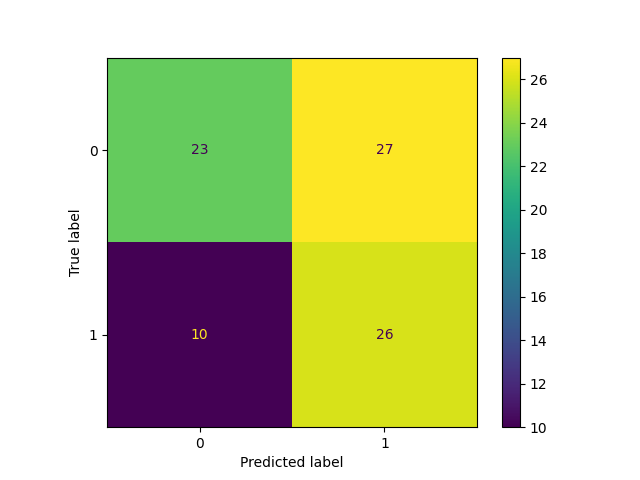

In [22]:
############# Train XGBoost Model ##############
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
#param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [3, 6, 9],
#    'learning_rate': [0.1, 0.2, 0.3],
#    'subsample': [0.8, 1.0],
#    'colsample_bytree': [0.8, 1.0],
#    'gamma': [0, 0.1, 0.2],
#    'reg_alpha': [0, 0.1, 0.5],
#    'reg_lambda': [1, 1.5, 2]
#}

param_grid = {
    'colsample_bytree': [0.8],
    'gamma': [0.1],
    'learning_rate': [0.2],
    'max_depth': [6],
    'n_estimators': [100],
    'reg_alpha': [0],
    'reg_lambda': [2],
    'subsample': [0.8]
}

# Initialize the model
XGB = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=XGB, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV to find the best parameters (assuming you have training data `X_train` and `y_train`)
grid_search.fit(X_train, y_train)

# Output the best parameters
print(grid_search.best_params_)

# Use the best estimator for predictions
best_model_XGB = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model_XGB.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
#print(X.columns)
print(best_model_XGB.feature_importances_)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model_XGB, X_test, y_test)

Accuracy: 0.5232558139534884
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.42      0.51        50
           1       0.45      0.67      0.54        36

    accuracy                           0.52        86
   macro avg       0.54      0.54      0.52        86
weighted avg       0.56      0.52      0.52        86



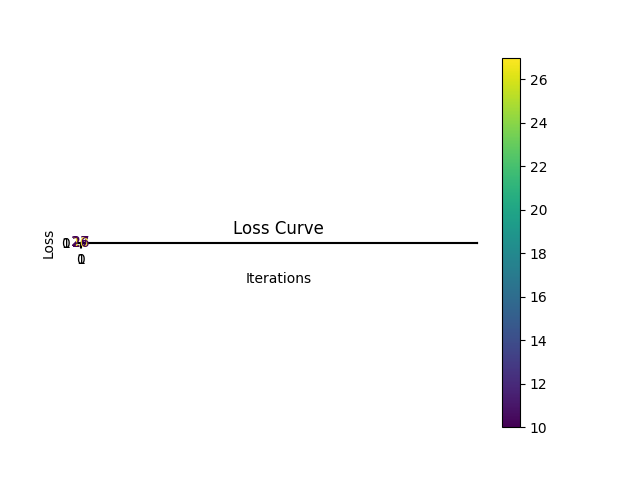

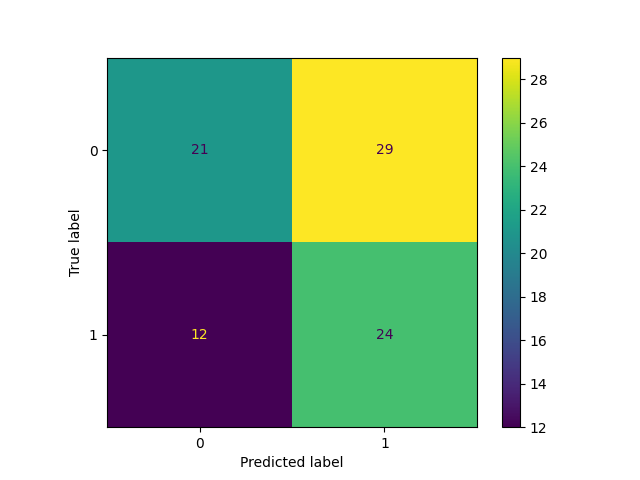

In [23]:
######## Train Simple Neural Network ##################

# Create an MLP classifier
mlp = MLPClassifier(
    hidden_layer_sizes=(100,100),
    max_iter=1000,
    solver='adam',
    random_state=42,
    learning_rate='constant',
    learning_rate_init=0.001,
    early_stopping=False,
    tol = 1e-8,
    n_iter_no_change = 100)


# Train the model
mlp.fit(X_train, y_train)

# Predict on test data
y_pred = mlp.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the loss curve
plt.plot(mlp.loss_curve_)
plt.title("Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()


ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test)

Train Accuracy: 0.48004314994606256
Test Accuracy: 0.4418604651162791


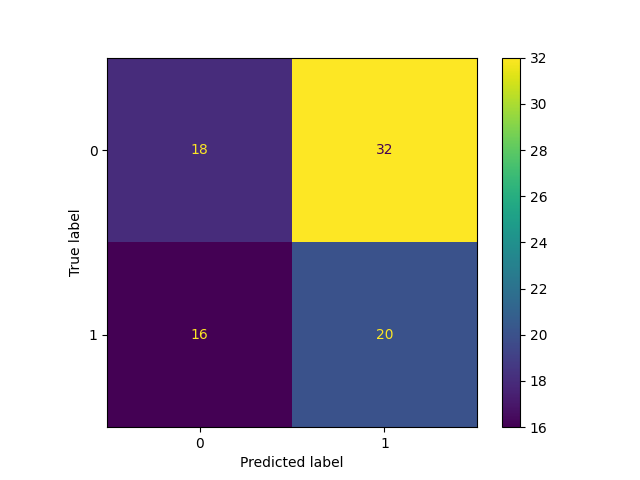

In [24]:
############# Train Support Vector Maching (SVM) #########
# Initialize lists to store training sizes and corresponding accuracies
training_sizes = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

# Loop over different training set sizes
svm = SVC(kernel='sigmoid', random_state=42)
svm.fit(X_train, y_train)

# Predict on the training and test data
y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)

# Calculate accuracy for the training and test data
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('Train Accuracy:',train_accuracy)
print('Test Accuracy:',test_accuracy)

ConfusionMatrixDisplay.from_estimator(svm, X_test, y_test)

Proquest Prompt2: Random forest shows highest accuracy at 61.6% accuracy.
